## Importing Packages & Loading the Data

In [1]:
#importing packages

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [65]:
#!pip install fbprophet

In [3]:
#read in all datasets

#median rent asking price for studio, 1br and 3br+
rent_studio = pd.read_csv('csvs/medianAskingRent_Studio.csv')
rent_1br = pd.read_csv('csvs/medianAskingRent_OneBd.csv')
rent_3br_plus = pd.read_csv('csvs/medianAskingRent_ThreePlusBd.csv')

#inventory for studio, 1br and 3br+
inv_studio = pd.read_csv('csvs/rentalInventory_Studio.csv')
inv_1br = pd.read_csv('csvs/rentalInventory_OneBd.csv')
inv_3br_plus = pd.read_csv('csvs/rentalInventory_ThreePlusBd.csv')

In [6]:
#We'll be using rent data from 2015 to May 2020

rent_studio.head(3)

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05
0,All Downtown,Manhattan,submarket,2350.0,2300.0,2200.0,2263.0,2300.0,2300.0,2290.0,...,2900.0,2950.0,2995.0,3000.0,3000.0,3000.0,3000.0,2999.0,2936.0,2850.0
1,All Midtown,Manhattan,submarket,2000.0,1995.0,1995.0,2000.0,2000.0,2000.0,2050.0,...,2699.0,2700.0,2695.0,2700.0,2700.0,2700.0,2760.0,2800.0,2795.0,2695.0
2,All Upper East Side,Manhattan,submarket,1750.0,1750.0,1750.0,1780.0,1800.0,1750.0,1750.0,...,2150.0,2150.0,2150.0,2195.0,2275.0,2250.0,2250.0,2267.0,2300.0,2225.0


In [7]:
#transpose dataset, rename columns, change index to datetime object

#studio
studio_df = rent_studio.T
studio_df.columns = rent_studio.iloc[:,0]
studio_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
studio_df.index = pd.to_datetime(studio_df.index)

#1br
onebr_df = rent_1br.T
onebr_df.columns = rent_1br.iloc[:,0]
onebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
onebr_df.index = pd.to_datetime(onebr_df.index)

#3br+
threebr_df = rent_3br_plus.T
threebr_df.columns = rent_3br_plus.iloc[:,0]
threebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
threebr_df.index = pd.to_datetime(threebr_df.index)

## Overview of Neighborhoods

Neighborhoods:

- Astoria
- Greenpoint
- Woodside

In [8]:
#filter dataframes | we only want 2015-2020 rental data of the three neighborhoods mentioned above

agw_studios = studio_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_1br = onebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_3br = threebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]

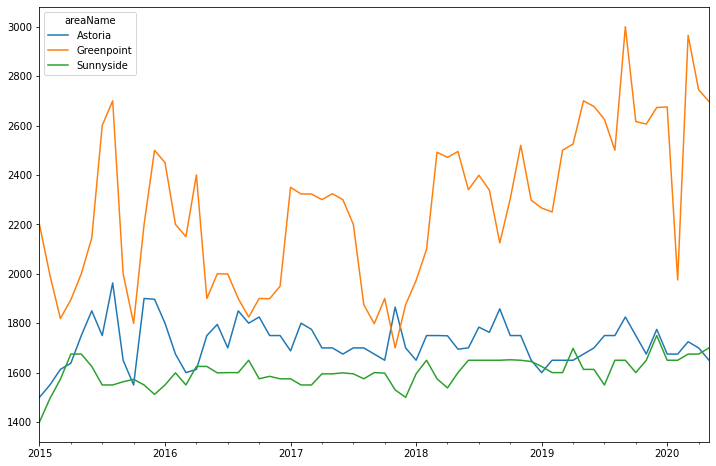

In [9]:
#rental data for studios across 5 years

agw_studios.plot(figsize=(12,8))

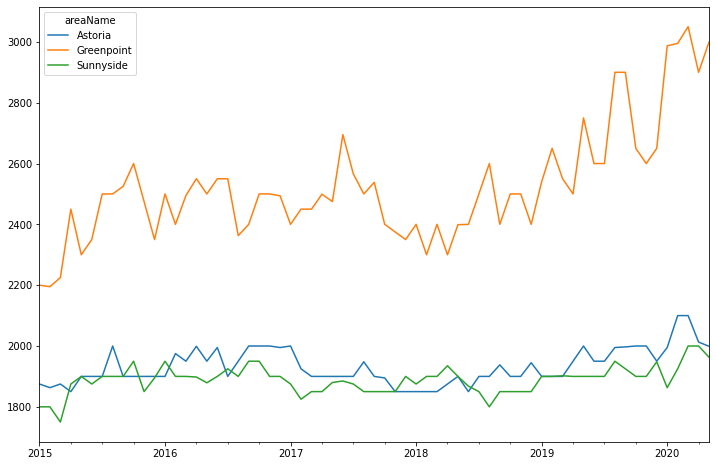

In [279]:
#rental data for one bedrooms across 5 years
agw_1br[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

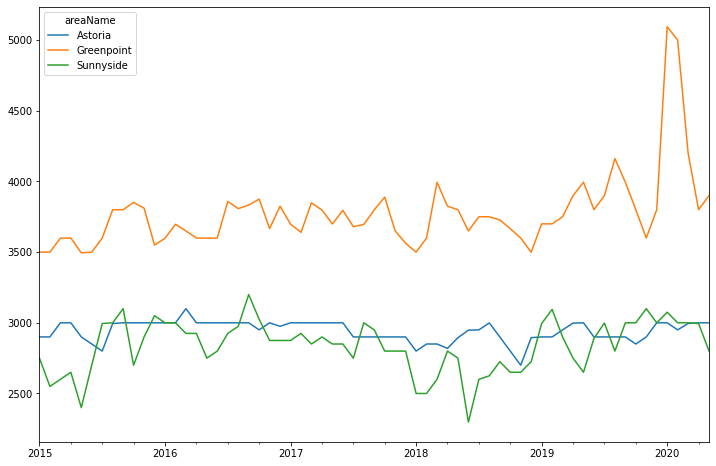

In [280]:
#rental data for three bedrooms+ across 5 years
agw_3br[['Astoria', 'Greenpoint', 'Sunnyside']].plot(figsize=(12,8))

## Distribution of Rental Data Across Neighborhoods & Rental Types

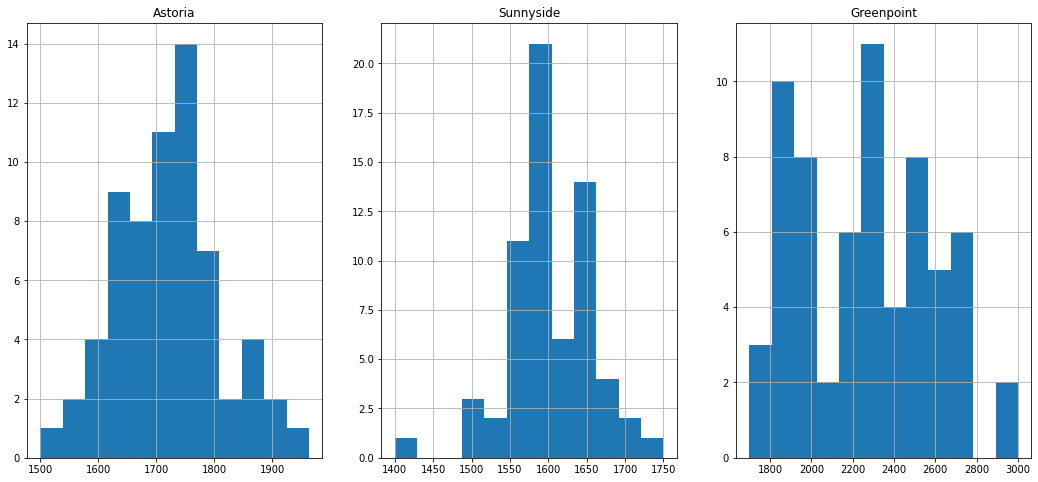

In [284]:
#studios median rent distribution

fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(18,8))
agw_studios['Astoria'].hist(ax=ax, bins=12)
ax.set_title('Astoria')
agw_studios['Sunnyside'].hist(ax=ax2, bins=12)
ax2.set_title('Sunnyside')
agw_studios['Greenpoint'].hist(ax=ax3, bins=12)
ax3.set_title('Greenpoint')
plt.show()

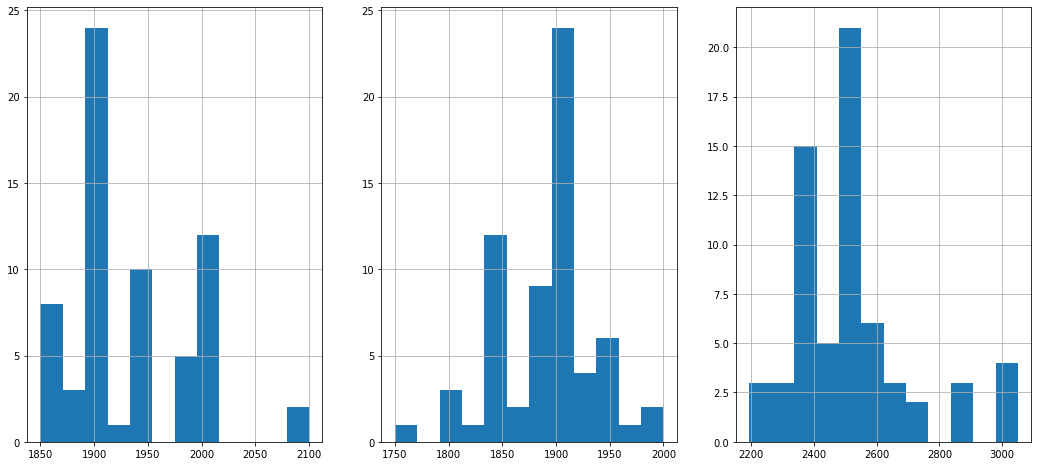

In [285]:
#one bedrooms median rent distribution

fig2, (ax4,ax5,ax6) = plt.subplots(1,3, figsize=(18,8))
agw_1br['Astoria'].hist(ax=ax4, bins=12)
ax.set_title('Astoria')
agw_1br['Sunnyside'].hist(ax=ax5, bins=12)
ax2.set_title('Sunnyside')
agw_1br['Greenpoint'].hist(ax=ax6, bins=12)
ax3.set_title('Greenpoint')
plt.show()

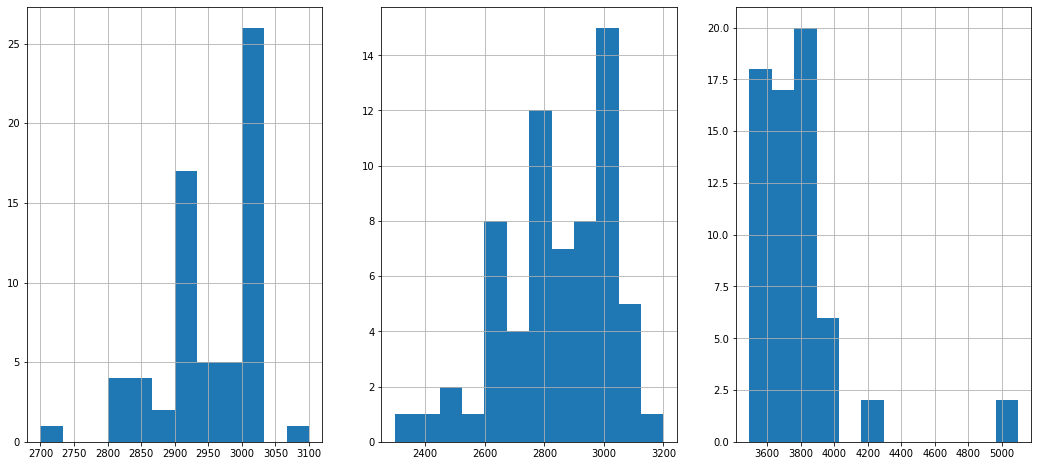

In [286]:
#three bedrooms+ median rent distribution

fig3, (ax7,ax8,ax9) = plt.subplots(1,3, figsize=(18,8))
agw_3br['Astoria'].hist(ax=ax7, bins=12)
ax.set_title('Astoria')
agw_3br['Sunnyside'].hist(ax=ax8, bins=12)
ax2.set_title('Sunnyside')
agw_3br['Greenpoint'].hist(ax=ax9, bins=12)
ax3.set_title('Greenpoint')
plt.show()